In [ ]:
%pip install Cython ripser persim datasets

In [ ]:
#!pip3 install git+https://github.com/simonzhang00/ripser-plusplus.git

In [2]:
import numpy as np
import pandas as pd
import persim
import ripser
from datasets import load_dataset

In [12]:
def encode_nucleotide_to_vector(nucleotide):
    """Map nucleotide to its corresponding 4D unit vector."""
    mapping = {'a': np.array([1, 0, 0, 0]),
               'c': np.array([0, 1, 0, 0]),
               'g': np.array([0, 0, 1, 0]),
               't': np.array([0, 0, 0, 1])}
    return mapping[nucleotide]

def C4DR(dna_sequence):
    """Transform a DNA sequence into its Chaos 4-dimensional Representation."""
    # Encode the first nucleotide to its corresponding vector
    points = [encode_nucleotide_to_vector(dna_sequence[0])]

    # Iterate over the DNA sequence starting from the second character
    for nucleotide in dna_sequence[1:]:
        # Encode nucleotide to vector
        vector = encode_nucleotide_to_vector(nucleotide)
        # Calculate the next point as the midpoint between the last point and the current vector
        next_point = 0.5 * (points[-1]) +(0.5* vector)
        points.append(next_point)

    return np.array(points)

# Example DNA sequence
dna_sequence = "aaaaaacggggggggggggatcggggggggggggatcggggggggggggatcggggggggggggatcggggggggggggatcggggggggggggatcggggggggggggatcggggggggggggatcggggggggggggatcggggggggggggatcggggggggggggatcgggggggggggg"

# Get the C4DR representation
c4dr_points = C4DR(dna_sequence)
print("C4DR Points:\n", c4dr_points)


C4DR Points:
 [[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.00000000e-01 5.00000000e-01 0.00000000e+00 0.00000000e+00]
 [2.50000000e-01 2.50000000e-01 0.00000000e+00 5.00000000e-01]
 ...
 [2.57609115e-02 9.52168135e-02 8.78990800e-01 3.14752112e-05]
 [1.28804557e-02 4.76084068e-02 9.39495400e-01 1.57376056e-05]
 [5.06440228e-01 2.38042034e-02 4.69747700e-01 7.86880280e-06]]


In [3]:
ds = load_dataset('Hack90/virus_5kbp_100kbp')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/112177 [00:00<?, ? examples/s]

In [4]:
df = pd.DataFrame(ds['train'])

In [5]:
df.Organism_Name.value_counts().to_csv('Virus_species.csv')

In [36]:
wnv = df[df.Organism_Name == 'West Nile virus']
dv = df[df.Organism_Name.str.contains('Dengue')]
cv = df[df.Organism_Name.str.contains('Chik')]

In [37]:
# were sampling every 7th point as the algorithm is memory intensive
c4dr_points_wnv1 = C4DR(wnv['Sequence'].values[0].lower()[::7])
c4dr_points_wnv2 = C4DR(wnv['Sequence'].values[2].lower()[::7])
c4dr_points_wnv3 = C4DR(wnv['Sequence'].values[4].lower()[::7])
c4dr_points_dv = C4DR(dv['Sequence'].values[0].lower()[::7])
c4dr_points_cv = C4DR(cv['Sequence'].values[0].lower()[::7])

In [38]:
dgm_wnv2 = ripser.ripser(c4dr_points_wnv1, maxdim=1)['dgms'][1]
dgm_wnv1 = ripser.ripser(c4dr_points_wnv2, maxdim=1)['dgms'][1]
dgm_wnv3 = ripser.ripser(c4dr_points_wnv3,  maxdim=1)['dgms'][1]
dgm_dv = ripser.ripser(c4dr_points_dv, maxdim=1)['dgms'][1]
dgm_cv = ripser.ripser(c4dr_points_cv, maxdim=1)['dgms'][1]

In [39]:
persim.sliced_wasserstein(dgm_wnv2, dgm_cv)

0.9223050492968448

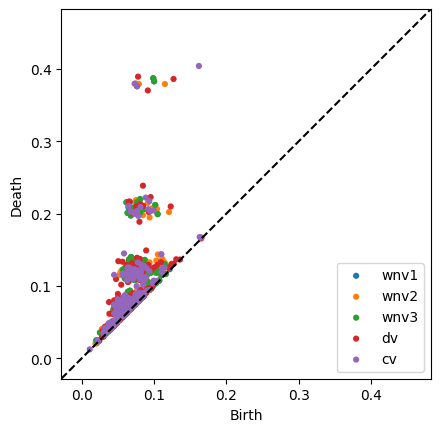

In [24]:
persim.plot_diagrams([dgm_wnv1, dgm_wnv2,dgm_wnv3,dgm_dv,dgm_cv ] , labels=['wnv1', 'wnv2','wnv3','dv','cv'])
